# Testing CNN Shape Measurements of Simple Galaxy Models

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde, pearsonr

#tensorflow
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
print("Tensorflow version: {}".format(tf.version.VERSION))



#keras only after gpu ID and memory usage is set
import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
import tensorflow.keras.regularizers as kr
import tensorflow.keras.optimizers as ko

import tensorflow_datasets as tfds

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Tensorflow version: 2.7.0


## CNN Models

In [2]:
def Ribli19(imsize=50, n_target=2 ,n_channels=1, nf=64, reg = 5e-5,
          padding='same', gpu='0'):

    #input
    inp = kl.Input((imsize, imsize,n_channels))
    
    # conv block 1
    x = kl.Conv2D(nf, (3, 3), padding=padding,kernel_regularizer=kr.l2(reg))(inp)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(nf, (3, 3), padding=padding,kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.MaxPooling2D(strides=(2,2))(x)
    
    # conv block 2
    x = kl.Conv2D(2*nf, (3, 3), padding=padding,kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(2*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.MaxPooling2D(strides=(2,2))(x)

    # conv block 3
    x = kl.Conv2D(4*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(2*nf, (1, 1), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(4*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    x = kl.MaxPooling2D(strides=(2,2))(x)

    # conv block 4
    x = kl.Conv2D(8*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(4*nf, (1, 1), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(8*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    x = kl.MaxPooling2D(strides=(2,2))(x)
    
    # conv block 5
    x = kl.Conv2D(16*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(8*nf, (1, 1), padding=padding,  kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(16*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    #  end of conv
    
    x = kl.GlobalAveragePooling2D()(x)    
    x = kl.Dense(n_target, name = 'final_dense_n%d_ngpu%d' % (n_target, len(gpu.split(','))))(x)  

    model = km.Model(inputs=inp, outputs=x)  # make model
       
    return model

In [3]:
# TODO: Enet untrained
# TODO: VGG16 pre-trained

## Load Data

In [4]:
import autometacal as amc

In [5]:
(datat, datav), ds_info = tfds.load('GalGen/small_stamp_100k',as_supervised=True,split=['train[:14%]', 'train[14%:20%]'],with_info=True)
datat = datat.cache()
datat = datat.shuffle(ds_info.splits['train'].num_examples)
datat = datat.batch(512)
datat = datat.prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
datav = datav.cache()
datav = datav.batch(512)
datav = datav.prefetch(tf.data.experimental.AUTOTUNE)

## Generate Model

In [7]:
model = Ribli19(51,n_channels=1)

## Optimise Model

In [8]:
sgd = ko.SGD(lr=0.005, decay=0., momentum=0.9, nesterov=True)
model.compile(loss='mse',optimizer=sgd, metrics=['mae','mse'])

model.fit(datat,
          epochs=40,
          validation_data=datav,
          verbose=1)

sgd = ko.SGD(lr=0.0005, decay=0., momentum=0.9, nesterov=True)
model.compile(loss='mse',optimizer=sgd, metrics=['mae','mse'])

model.fit(datat,
          epochs=20,
          validation_data=datav,
          verbose=1)

sgd = ko.SGD(lr=0.00005, decay=0., momentum=0.9, nesterov=True)
model.compile(loss='mse',optimizer=sgd, metrics=['mae','mse'])

model.fit(datat,
          epochs=20,
          validation_data=datav,
          verbose=1)

/local/home/az264973/.local/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/40
28/28 [==============================] - 15s 331ms/step - loss: 0.3607 - mae: 0.2519 - mse: 0.1674 - val_loss: 0.2535 - val_mae: 0.1974 - val_mse: 0.0600
Epoch 2/40
28/28 [==============================] - 7s 237ms/step - loss: 0.1972 - mae: 0.0455 - mse: 0.0038 - val_loss: 0.2524 - val_mae: 0.1955 - val_mse: 0.0590
Epoch 3/40
28/28 [==============================] - 7s 238ms/step - loss: 0.1965 - mae: 0.0415 - mse: 0.0031 - val_loss: 0.2508 - val_mae: 0.1929 - val_mse: 0.0574
Epoch 4/40
28/28 [==============================] - 7s 238ms/step - loss: 0.1960 - mae: 0.0388 - mse: 0.0027 - val_loss: 0.2481 - val_mae: 0.1885 - val_mse: 0.0548
Epoch 5/40
28/28 [==============================] - 7s 240ms/step - loss: 0.1950 - mae: 0.0287 - mse: 0.0017 - val_loss: 0.2434 - val_mae: 0.1806 - val_mse: 0.0502
Epoch 6/40
28/28 [==============================] - 7s 240ms/step - loss: 0.1966 - mae: 0.0449 - mse: 0.0033 - val_loss: 0.2416 - val_mae: 0.1782 - val_mse: 0.0484
Epoch 7/40
28/2

## Predict on Test Set

In [9]:
test  = datav

#predictions
predictions = model.predict(test)

#labels
test_unb  = test.unbatch()
test_unb_it = test_unb.as_numpy_iterator()
listtest  = [next(test_unb_it) for i in range(len(predictions))]
labels = np.array([listtest[i][1] for i in range(len(predictions))])

## Plot the Results

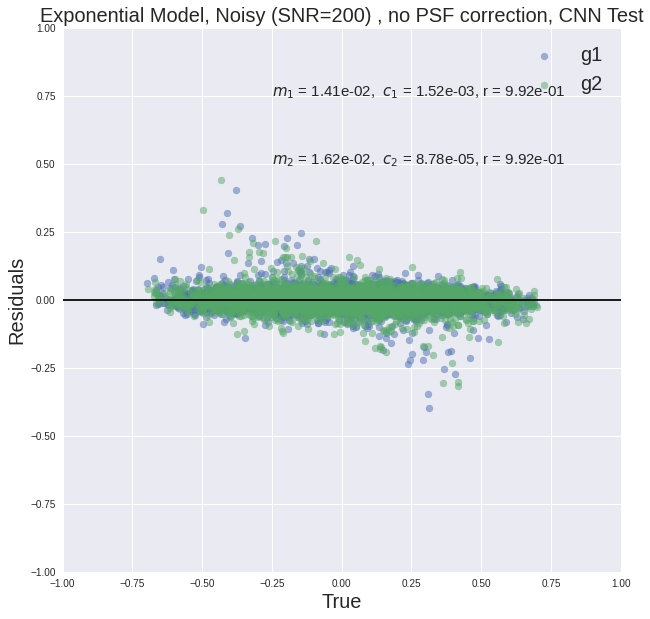

In [10]:
plt.style.use('seaborn')
plt.figure(figsize=(10,10))

#linear fit
poly_g1 = np.polyfit(labels[:,0],predictions[:,0],1)
poly_g2 = np.polyfit(labels[:,1],predictions[:,1],1)

#correlation coefficient
corr_g1 = pearsonr(labels[:,0],predictions[:,0])
corr_g2 = pearsonr(labels[:,1],predictions[:,1])

#plots
plt.scatter(labels[:,0],predictions[:,0]-labels[:,0],alpha=0.5,label='g1')
plt.scatter(labels[:,1],predictions[:,1]-labels[:,1],alpha=0.5,label='g2')

#text
plt.text(-.25,0.75, "$m_1$ = {:.2e},  $c_1$ = {:.2e}, r = {:.2e}".format(1-poly_g1[0],poly_g1[1],corr_g1[0]),fontsize=15)
plt.text(-.25,0.5 , "$m_2$ = {:.2e},  $c_2$ = {:.2e}, r = {:.2e}".format(1-poly_g2[0],poly_g2[1],corr_g2[0]),fontsize=15)

#zero
plt.plot([-1,1],[0,0],'k-')

#settings
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.title("Exponential Model, Noisy (SNR=200) , no PSF correction, CNN Test",fontsize=20)
plt.xlabel("True",fontsize=20)
plt.ylabel("Residuals",fontsize=20)
plt.legend(fontsize=20)

#save
plt.savefig("first_test.pdf",bbox_inches="tight",facecolor='white')

## Metacal on Ribli